In [75]:
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import statistics
import seaborn as sns; sns.set(style="whitegrid")
import math
%run Cointegration.py
%matplotlib inline

In [77]:
df = pd.read_csv('datasets/data.csv', index_col=0)

In [50]:
data = pd.read_excel('datasets/dados-ser.xlsx', index_col=0)
data = data[['BBAS3', 'CSAN3']]
data = data.iloc[0:409]
#data = data.iloc[::-1]
#data.reset_index(inplace=True)

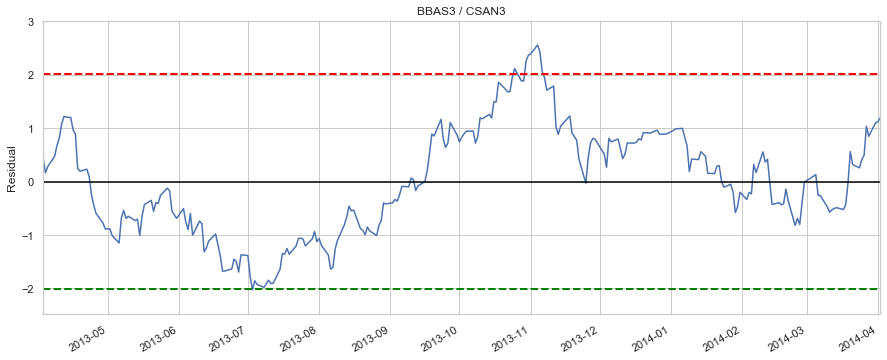

In [52]:
gra = data[::-1]
show(gra, 'BBAS3', 'CSAN3')

In [53]:
numbers = np.arange(1, len(data)+1)
data['Dudiv'] = numbers

In [54]:
data['Du'] = 140 - numbers + 1

In [55]:
data

,BBAS3,CSAN3,Dudiv,Du
Data,,,,
2014-04-02,22.85,34.86,1,140
2014-04-01,22.78,35.10,2,139
2014-03-31,22.80,35.26,3,138
2014-03-28,22.22,35.05,4,137
2014-03-27,22.51,34.80,5,136
...,...,...,...,...
2012-08-10,20.68,31.11,405,-264
2012-08-09,20.01,31.58,406,-265
2012-08-08,20.43,32.07,407,-266


In [58]:
model = model_ols(gra['BBAS3'], gra['CSAN3'])
model.params

const    10.088305
CSAN3     0.296712
dtype: float64

In [97]:
# define functions
def load_data():
# set the working directory
    import os
    #os.getcwd() # this is to check the current working directory
    #os.chdir("D://EPAT//09 FP//")
    all_contracts = pd.read_csv('training data.csv',index_col='tradeDate',parse_dates=True)
    p_sorted = pd.read_csv('training_p_sorted.csv',index_col='id',parse_dates=False)
    
    return all_contracts,p_sorted

def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
 
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
 
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
 
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0


###############################################################################
##### ADF TEST
###############################################################################
def adf_test(x, y):
    df = pd.DataFrame({'y':y,'x':x})
    est = sm.OLS(df.y, df.x)
    est = est.fit()
    df['hr'] = -est.params[0]
    df['spread'] = df.y + (df.x * df.hr)
    
    cadf = ts.adfuller(df.spread)   
    return cadf[1] 
 
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    
    spread_lag2 = sm.add_constant(spread_lag)
     
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
 
    if halflife <= 0:
        halflife = 1
    return halflife    

def KalmanFilterAverage(x):
    # Construct a Kalman filter
    from pykalman import KalmanFilter
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

#  Kalman filter regression
def KalmanFilterRegression(x,y):

    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                      initial_state_mean=[0,0],
                      initial_state_covariance=np.ones((2, 2)),
                      transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,
                      observation_covariance=2,
                      transition_covariance=trans_cov)
    
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means    


In [132]:
pos = len(gra)-200
y=gra['BBAS3'][pos:]
x=gra['CSAN3'][pos:]

In [135]:
#run regression to find hedge ratio
#and then create spread series
df1 = pd.DataFrame({'y':y,'x':x})
state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))

df1['hr'] = - state_means[:,0]
df1['spread'] = df1.y + (df1.x * df1.hr)

halflife = half_life(df1['spread'])

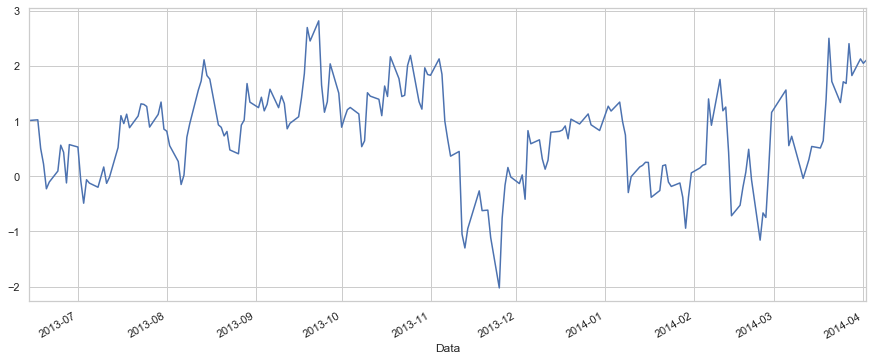

In [136]:
df1['spread'].plot(figsize=(15,6))

In [129]:
y, x = getvalues_by_period(df['B3SA3'], df['BPAC11'],250)

In [130]:
df1 = pd.DataFrame({'y':y,'x':x})
state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))

df1['hr'] = - state_means[:,0]
df1['spread'] = df1.y + (df1.x * df1.hr)

halflife = half_life(df1['spread'])

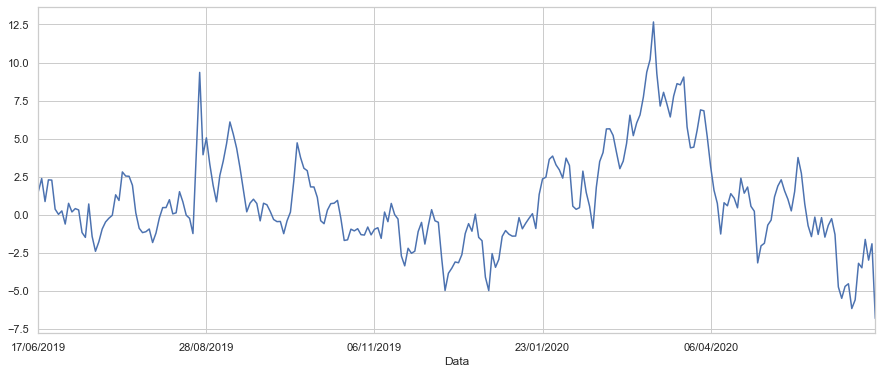

In [131]:
df1['spread'].plot(figsize=(15,6))